In [28]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram
from neuropy.io.usvio import detect_tone

from tracefc.io.session_directory import get_session_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [6]:
animal, sess_name = 'Finn', 'recall1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

No dat file found, not loading
filename: /Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [7]:
print(sess.eegfile)

duration: 4002.59 seconds 
duration: 1.11 hours 



### Load in disconnect and motion artifacts

In [8]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")

art_epochs = Epoch(epochs=None, file=art_epochs_file)

art_epochs

24 epochs
Snippet: 
       start      stop label
0   93.8680  117.6120      
1  131.7952  132.3752      
2  146.7120  147.0232      
3  206.8288  210.6568      
4  218.6744  222.6240      

<Axes: >

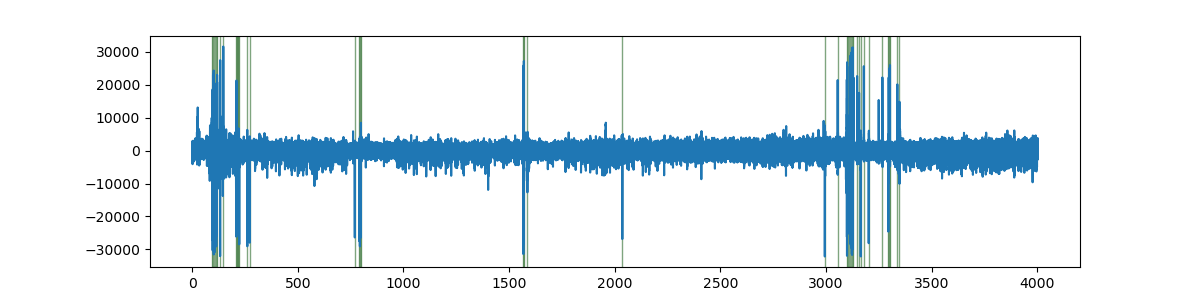

In [9]:
%matplotlib widget

chan_plot = 28
plot_signal_w_epochs(signal, 28, art_epochs)

## Define probe group

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

## Detect Theta epochs

In [ ]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 31

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

## Detect SWR Epochs

In [ ]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 29
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


## Sync via CS+ or CS- times in tone_recall or control_tone_recall or tone_habituation session

,channel_states,timestamps,datetimes,event_name
633,2,3817174,2022-01-21 12:39:00.239133333,
634,-2,4114849,2022-01-21 12:39:10.161633333,
828,2,6215216,2022-01-21 12:40:20.173866667,
977,-2,6513350,2022-01-21 12:40:30.111666667,
1779,2,8133652,2022-01-21 12:41:24.121733333,


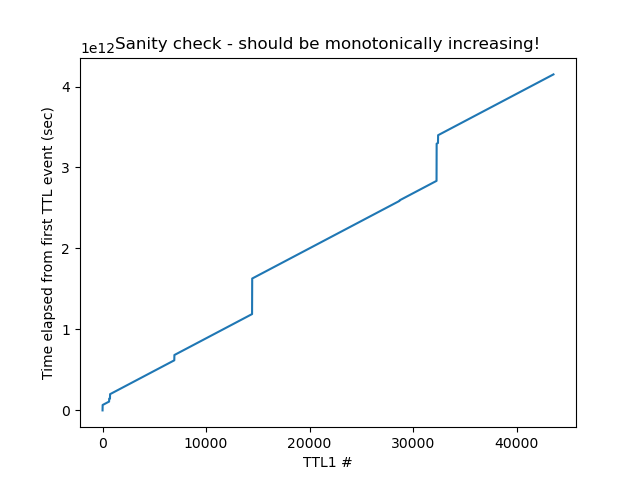

In [10]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [47]:
import tracefc.io.traceio as traceio

# For tone recall CS+
cs_starts, cs_stops, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS+ events detected')
print(cs_starts.head(6))

# For control tone recall CS-
csn_starts, csn_stops, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS-", return_df=True)
print(f'{csn_starts.shape[0]} CS- events detected')
print(csn_starts.head(6))

15 CS+ events detected
      Time (s)      Event                     Timestamp
9    60.992706  CS1_start 2022-01-21 12:39:00.826961060
11  140.927233  CS2_start 2022-01-21 12:40:20.761488219
13  204.874969  CS3_start 2022-01-21 12:41:24.709224482
15  264.824631  CS4_start 2022-01-21 12:42:24.658886214
17  325.753973  CS5_start 2022-01-21 12:43:25.588227530
19  388.704585  CS6_start 2022-01-21 12:44:28.538840314
12 CS- events detected
      Time (s)      Event                     Timestamp
5    60.840526  CS1_start 2022-01-21 13:05:10.721559627
7   128.764897  CS2_start 2022-01-21 13:06:18.645930870
9   194.714935  CS3_start 2022-01-21 13:07:24.595968587
11  261.665613  CS4_start 2022-01-21 13:08:31.546646936
13  337.597110  CS5_start 2022-01-21 13:09:47.478144033
15  404.545281  CS6_start 2022-01-21 13:10:54.426315410


In [17]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2022-01-21 12:30:50.731508-05:00
start time = 2022-01-21 12:30:50.731508-05:00
start time = 2022-01-21 12:36:53.592984-05:00
start time = 2022-01-21 12:59:46.424053-05:00
start time = 2022-01-21 13:28:32.606720-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-01-21 12:30:50.731508-05:00,start,0,0.000000,0,0.0000
1,0,2022-01-21 12:32:49.541074667-05:00,stop,3564287,118.809567,148511,118.8088
2,1,2022-01-21 12:34:38.989641333-05:00,start,3564288,118.809600,148512,118.8096
3,1,2022-01-21 12:35:11.322408-05:00,stop,4534271,151.142367,188927,151.1416
4,2,2022-01-21 12:36:53.592984-05:00,start,4534272,151.142400,188928,151.1424
5,2,2022-01-21 12:57:43.478817333-05:00,stop,42030847,1401.028233,1751285,1401.0280
6,3,2022-01-21 12:59:46.424053-05:00,start,42030848,1401.028267,1751286,1401.0288
7,3,2022-01-21 13:24:41.139753-05:00,stop,86872319,2895.743967,3619679,2895.7432
8,4,2022-01-21 13:28:32.606720-05:00,start,86872320,2895.744000,3619680,2895.7440
9,4,2022-01-21 13:46:59.704286667-05:00,stop,120085247,4002.841567,5003551,4002.8408


In [52]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.8, unit="seconds")
cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_stop_df = traceio.trace_ttl_to_openephys(cs_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
# Convert to times in combined eeg file
cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)
cs_stops_combined = oeio.recording_events_to_combined_time(cs_oe_stop_df, sync_df)

csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_stop_df = traceio.trace_ttl_to_openephys(csn_stops, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)
csn_stops_combined = oeio.recording_events_to_combined_time(csn_oe_stop_df, sync_df)

start time lag: mean = -0.5872398221333335, std = 0.0013713736007565883
start time lag: mean = -0.5887733233999999, std = 0.00013625709196786435
start time lag: mean = -0.4215331420000001, std = 0.00017972138044762675
start time lag: mean = -0.4226918540833333, std = 0.00013141926171571328


/Users/nkinsky/Documents/UM/GitHub/TraceFC/tracefc/io/traceio.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trace_cs_sync_df["datetimes"] = trace_cs_sync_df["datetimes"].dt.tz_localize(


### How to write CS+ to neuroscope event file

In [82]:
cs_tone_recall_epochs = Epoch({"start": cs_starts_combined, "stop": cs_stops_combined, "label": ["CS+"]*len(cs_starts_combined)})
cs_tone_recall_epochs
sess.recinfo.write_epochs(cs_tone_recall_epochs, "cs+")

<class 'pandas.core.frame.DataFrame'>


In [148]:
cs_starts_combined

array([ 277.788549,  357.723282,  421.671149,  481.620849,  542.550049,
        605.500649,  671.451216,  734.381249,  806.337449,  874.282349,
        951.213449, 1029.163449, 1109.113816, 1183.042882, 1260.993682])

In [151]:
cs_wav_epochs.starts + cs_start_lags

array([ 277.788549,  357.723282,  421.671149,  481.620849,  542.550049,
        605.500649,  671.451216,  734.381249,  806.337449,  874.282349,
        951.213449, 1029.163449, 1109.113816, 1183.042882, 1260.993682])

/Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/1_tone_recall/new_arena/T0000001.WAV
Mean start lag time of -185.387 sec with std = 0.041 sec. Add lags from wavfile times to get ephys times
Mean stop lag time of -185.675 sec with std = 0.045 sec.


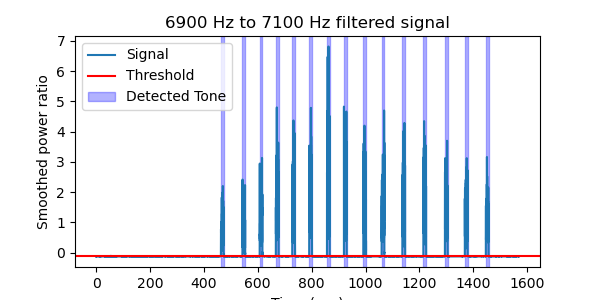

In [159]:
# Detect CS+ in audio recording.
tone_recall_wav = sorted((sess.basepath / "1_tone_recall").glob("**/*.WAV"))[0]
print(tone_recall_wav)

# Get CS+ times and plot to check
cs_wav_epochs = detect_tone(tone_recall_wav, freq_lims=(6900, 7100), thresh=-0.1, tone_length=10, tone_label="CS+", plot_check=True)

# Check that lags are consistent
cs_start_lags = cs_starts_combined - cs_wav_epochs.starts
print(f"Mean start lag time of {np.mean(cs_start_lags):0.3F} sec with std = {np.std(cs_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
cs_stop_lags = cs_stops_combined - cs_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(cs_stop_lags):0.3F} sec with std = {np.std(cs_stop_lags):0.3F} sec.")

Ditto for CS-

/Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/2_control_tone_recall/new_arena2/T0000002.WAV
Mean start lag time of 1468.805 sec with std = 0.035 sec. Subtract lags from wavfile times to get ephys times
Mean stop lag time of 1468.512 sec with std = 0.063 sec.


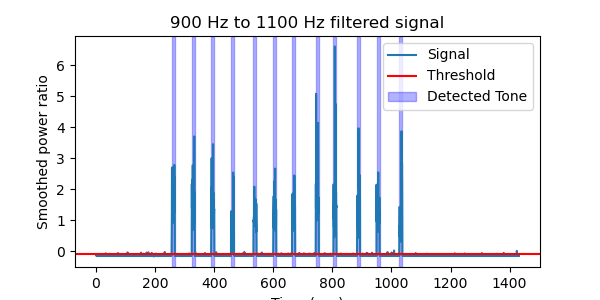

In [103]:
# Detect CS- in audio recording.
control_tone_recall_wav = sorted((sess.basepath / "2_control_tone_recall").glob("**/*.WAV"))[0]
print(control_tone_recall_wav)

# Get CS+ times and plot to check
csn_wav_epochs = detect_tone(control_tone_recall_wav, freq_lims=(900, 1100), thresh=-0.1, tone_length=10, tone_label="CS-", plot_check=True)

# Check that lags are consistent
csn_start_lags = csn_starts_combined - csn_wav_epochs.starts
print(f"Mean start lag time of {np.mean(csn_start_lags):0.3F} sec with std = {np.std(csn_start_lags):0.3F} sec. Add lags from wavfile times to get ephys times")
csn_stop_lags = csn_stops_combined - csn_wav_epochs.stops
print(f"Mean stop lag time of {np.mean(csn_stop_lags):0.3F} sec with std = {np.std(csn_stop_lags):0.3F} sec.")

Now try to sync to start tone 

/Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/3_ctx_recall/shock_box/T0000001.WAV


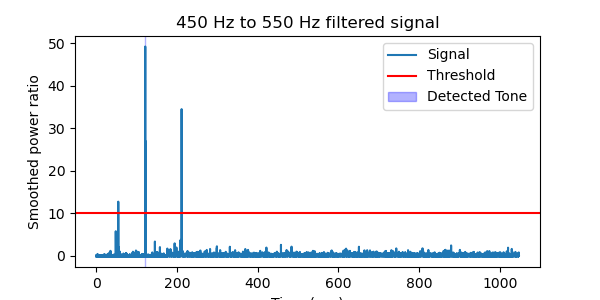

In [104]:
ctx_recall_wav = sorted((sess.basepath / "3_ctx_recall").glob("**/*.WAV"))[0]
print(ctx_recall_wav)

# Get CS+ times and plot to check
start_wav_epochs = detect_tone(ctx_recall_wav, freq_lims=(450, 550), thresh=10, tone_length=0.5, tone_label="start_tone", plot_check=True)

## Sync recorded USV times to ephys file

In [145]:
# Read in USV times from tone recall session
from neuropy.io.usvio import DeepSqueakIO
usv_detect_file = sorted(tone_recall_wav.parent.glob(f"**/{tone_recall_wav.name[:-4]}*_cell.mat"))[0]

ds_calls = DeepSqueakIO(filename=usv_detect_file)
ds_calls.load_calls()
ds_calls.usv_df

,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept
0,134.184448,46.000000,0.020000,10.375000,0.564256,0
1,155.295240,46.000000,0.070000,50.375000,0.530661,0
2,284.025116,28.625000,0.080000,27.375000,0.530108,0
3,349.470060,29.125000,0.040000,71.625000,0.574179,0
4,350.930060,29.125000,0.040000,71.625000,0.574179,0
...,...,...,...,...,...,...
188,1562.018244,14.519932,1.159503,29.108485,0.615512,1
189,1563.208820,13.666856,0.919068,32.646071,0.610592,1
190,1564.161220,16.591686,0.971291,29.111902,0.610592,1
191,1565.172252,18.054100,0.663767,29.233770,0.610592,1


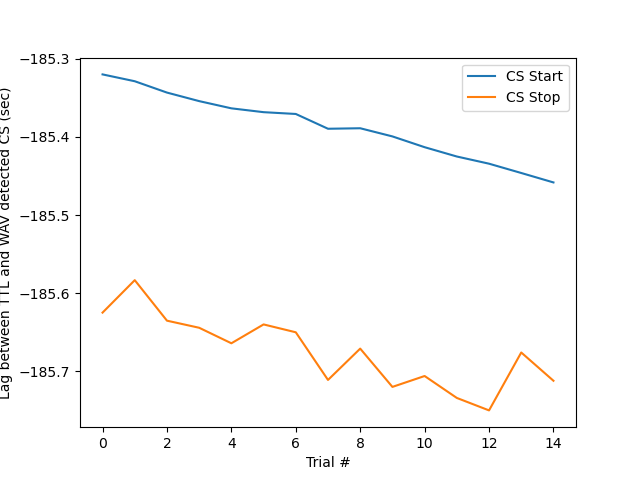

In [162]:
# There appears to be drift between the audio recording and the ephys recording timestamps.  Not much, but about 100ms.
# Write function to get a rough estimate of times based on average lag and then write more advanced one to interpolate it!
# Use similar idea to sync_df for open ephys recordings.  
_, ax = plt.subplots()
hl = ax.plot(np.stack((cs_start_lags, cs_stop_lags), axis=1))
ax.set_xlabel('Trial #')
ax.set_ylabel('Lag between TTL and WAV detected CS (sec)')
ax.legend(hl, ('CS Start', 'CS Stop'))

## Save notebook to working directory

In [64]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/Users/nkinsky/Documents/UM/GitHub/TraceFC/Notebooks/Sync_USV_and_Ephys.ipynb saved to /Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Finn/2022_01_21_recall1/Finn_recall1_Sync_USV_and_Ephys.ipynb
